# SECS Inversion and Visualization Test

This notebook demonstrates the Spherical Elementary Current Systems (SECS) inversion process and visualization techniques using magnetometer data. It processes 9 time steps from 2024-05-10 at 21:00 to 21:40 (in 5-minute intervals) and creates two types of visualizations:

1. **SECS Comparison Plots**: Shows the comparison between SECS-predicted magnetic fields and actual magnetometer observations
2. **RGB Visualization**: Displays the magnetic field components as RGB color channels

## Table of Contents

1. [Setup and Configuration](#1-setup-and-configuration)
   - Import libraries
   - Define parameters
   - Set up directories

2. [SECS Inversion Process](#2-secs-inversion-process)
   - 2.1 Load magnetometer data
   - 2.2 Set up SECS grid
   - 2.3 Calculate SECS matrices
   - 2.4 Process timestamps

3. [SECS Comparison Visualization](#3-secs-comparison-visualization)
   - Generate comparison plots
   - Display 3×3 grid of comparison plots

4. [RGB Visualization](#4-rgb-visualization)
   - Generate RGB images from magnetic field components
   - Display 3×3 grid of RGB images

## What are Spherical Elementary Current Systems (SECS)?

SECS is a mathematical method used to analyze and visualize ionospheric currents and their associated magnetic fields. The method works by:

1. **Setting up a grid of elementary current systems** in the ionosphere (about 110 km above Earth's surface)
2. **Measuring magnetic field variations** at ground-based magnetometer stations
3. **Solving an inverse problem** to find the current amplitudes that best explain the observed magnetic fields
4. **Calculating the resulting magnetic field** at any location using the estimated currents

This approach allows us to create a continuous map of magnetic field variations over a region, even in areas without direct measurements.

The inverse problem is mathematically challenging because it's underdetermined (more unknowns than measurements) and requires regularization techniques to obtain physically meaningful solutions.

## 1. Setup and Configuration

First, we'll import the necessary libraries and set up our configuration parameters. Instead of calling external scripts, we'll directly use the functions from the helper_functions.py module.

In [1]:
# Import standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from PIL import Image
from IPython.display import display, Image as IPImage

# Import additional required libraries for visualization
from secsy import CSplot
import warnings

# Suppress specific pcolormesh warnings
warnings.filterwarnings('ignore', 
                       message='The input coordinates to pcolormesh are interpreted as cell*',
                       category=UserWarning)
# Make sure the source directory is in the path so we can import our modules
sys.path.append('source')

# Import helper functions directly
from helper_functions import (
    create_dir, load_magnetometer_data, trailing_average, get_common_stations,
    create_secs_directories, save_magnetic_component, save_grid_metadata,
    setup_secs_grid, filter_stations_by_grid, calculate_secs_matrices, process_timestamp,
    create_rgb_image, save_rgb_image, load_magnetic_component
)

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12

# Define base directory and paths
base_dir = os.path.abspath('/Users/akv020/Tensorflow/fennomag-net/')  # Set your base directory here
print(f"Base directory: {base_dir}")

# Time range parameters
start_date_str = "2024-05-10 12:00"
end_date_str = "2024-05-10 12:40"  # 9 time steps with 5-minute intervals
start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d %H:%M')
time_interval = 5  # 5-minute intervals

# Generate timestamps for processing
timestamps = []
current_time = start_date
while current_time <= end_date:
    timestamps.append(current_time)
    current_time += timedelta(minutes=time_interval)

print(f"Processing {len(timestamps)} timestamps from {start_date} to {end_date}")
for i, ts in enumerate(timestamps):
    print(f"  {i+1}. {ts}")

# Grid parameters
grid_center = (15.0, 67.0)  # Longitude, Latitude in degrees
grid_shape = (20, 14)       # N-S points, E-W points
grid_resolution = 150       # Grid resolution in km

# Regularization parameters
l0 = 1e-2  # Zero-order (amplitude) regularization
l1 = 1e-2  # First-order (smoothness) regularization
mirror_depth = 1000  # Mirror depth in km (9999 to disable)

# Visualization parameters
vmin_comp = -1250  # Minimum value for comparison plots
vmax_comp = 1250   # Maximum value for comparison plots
vmin_rgb = -1250  # Minimum value for RGB visualization
vmax_rgb = 1250   # Maximum value for RGB visualization

# Data directories
data_dir = os.path.join(base_dir, "data")                # Base directory for magnetometer data
output_dir = os.path.join(base_dir, "source/secs_test")         # Output directory for SECS data

# Create output directory if it doesn't exist
create_dir(output_dir)
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")

Base directory: /Users/akv020/Tensorflow/fennomag-net
Processing 9 timestamps from 2024-05-10 12:00:00 to 2024-05-10 12:40:00
  1. 2024-05-10 12:00:00
  2. 2024-05-10 12:05:00
  3. 2024-05-10 12:10:00
  4. 2024-05-10 12:15:00
  5. 2024-05-10 12:20:00
  6. 2024-05-10 12:25:00
  7. 2024-05-10 12:30:00
  8. 2024-05-10 12:35:00
  9. 2024-05-10 12:40:00
Data directory: /Users/akv020/Tensorflow/fennomag-net/data
Output directory: /Users/akv020/Tensorflow/fennomag-net/source/secs_test


### Understanding the Parameters

Let's review the key parameters we've set:

1. **Time Range**: We're analyzing data from 2024-05-10 21:00 to 21:40 in 5-minute intervals, giving us 9 timestamps.

2. **Grid Parameters**:
   - **Center**: (17.0°E, 67.0°N) - This is in northern Scandinavia, a region with good magnetometer coverage
   - **Shape**: 32×32 points (N-S × E-W) - This gives us a grid with 540 SECS poles
   - **Resolution**: 100 km - The spacing between adjacent grid points
   - **Total Coverage**: Approximately 3200 km N-S × 3200 km E-W

3. **Regularization Parameters**:
   - **l0 (amplitude)**: 1e-2 - Controls the overall amplitude of the solution
   - **l1 (smoothness)**: 1e-2 - Controls the spatial smoothness of the solution
   - **Mirror Depth**: 1000 km - Accounts for Earth-induced currents

4. **Visualization Parameters**:
   - **vmin/vmax_comp**: ±1250 nT - Range for comparison plots
   - **vmin/vmax_rgb**: ±1250 nT - Range for RGB visualization

These parameters can be adjusted to analyze different regions, time periods, or to change the characteristics of the SECS solution.

## 2. SECS Inversion Process

Now we'll perform the SECS inversion process. We'll break this down into several steps for clarity:

1. Load and prepare magnetometer data
2. Set up the SECS grid and filter stations
3. Calculate SECS basis matrices
4. Process each timestamp to calculate magnetic fields

### 2.1 Load Magnetometer Data

First, we'll load the magnetometer data for the X, Y, and Z components and prepare it for processing.

In [2]:
def load_and_prepare_data():
    """Load magnetometer data and prepare it for SECS processing."""
    print("\n=== SECS Generator Configuration ===")
    print(f"Analysis period: {start_date} to {end_date}")
    print(f"Time resolution: {time_interval} minutes")
    print(f"Grid center: {grid_center[0]}°E, {grid_center[1]}°N")
    print(f"Grid shape: {grid_shape[0]}×{grid_shape[1]} points")
    print(f"Grid resolution: {grid_resolution} km")
    print(f"Regularization: l0={l0}, l1={l1}")
    print(f"Mirror depth: {'Disabled' if mirror_depth == 9999 else f'{mirror_depth} km'}")
    print("=====================================\n")
    
    # Define data directories for X, Y, Z components
    Xdir = os.path.join(data_dir, 'XYZmagnetometer/X')
    Ydir = os.path.join(data_dir, 'XYZmagnetometer/Y')
    Zdir = os.path.join(data_dir, 'XYZmagnetometer/Z')
    
    # Step 1: Load magnetometer data for all components within specified time range
    print("Loading magnetometer data...")
    data = load_magnetometer_data(start_date, end_date, Xdir, Ydir, Zdir)
    if any(data[comp] is None for comp in ['X', 'Y', 'Z']):
        raise ValueError("Could not load all magnetometer data files")
    
    # Display data summary
    for comp in ['X', 'Y', 'Z']:
        print(f"{comp} component data shape: {data[comp].shape}")
        print(f"Time range: {data[comp]['timestamp'].min()} to {data[comp]['timestamp'].max()}")
        print(f"Number of stations: {len(data[comp].columns) - 1}")  # -1 for timestamp column
    
    # Step 2: Load station coordinates and prepare for processing
    station_coords_file = os.path.join(data_dir, 'magnetometer/station_coordinates.csv')
    station_coordinates = pd.read_csv(station_coords_file)
    station_coordinates.set_index('station', inplace=True)
    
    print(f"Total stations in coordinates file: {len(station_coordinates)}")
    
    # Filter stations to keep only those with both coordinates and measurements
    common_stations = get_common_stations(data, station_coordinates)
    print(f"Number of common stations with both coordinates and measurements: {len(common_stations)}")
    
    for comp in ['X', 'Y', 'Z']:
        columns_to_keep = ['timestamp'] + common_stations
        data[comp] = data[comp][columns_to_keep]
    station_coordinates = station_coordinates.loc[common_stations]
    
    return data, station_coordinates, common_stations

# Load and prepare the data
data, station_coordinates, common_stations = load_and_prepare_data()


=== SECS Generator Configuration ===
Analysis period: 2024-05-10 12:00:00 to 2024-05-10 12:40:00
Time resolution: 5 minutes
Grid center: 15.0°E, 67.0°N
Grid shape: 20×14 points
Grid resolution: 150 km
Regularization: l0=0.01, l1=0.01
Mirror depth: 1000 km

Loading magnetometer data...
X component data shape: (41, 42)
Time range: 2024-05-10 12:00:00 to 2024-05-10 12:40:00
Number of stations: 41
Y component data shape: (41, 42)
Time range: 2024-05-10 12:00:00 to 2024-05-10 12:40:00
Number of stations: 41
Z component data shape: (41, 42)
Time range: 2024-05-10 12:00:00 to 2024-05-10 12:40:00
Number of stations: 41
Total stations in coordinates file: 39
Number of common stations with both coordinates and measurements: 39


### 2.2 Set Up SECS Grid

Next, we'll set up the SECS grid and filter the stations to keep only those inside the grid area.

In [3]:
def setup_grid_and_filter_stations(data, station_coordinates, common_stations):
    """Set up the SECS grid and filter stations to keep only those inside the grid."""
    # Step 3: Set up SECS grid
    print("\nSetting up SECS grid...")
    grid = setup_secs_grid(
        grid_center=grid_center,
        grid_shape=grid_shape,
        grid_resolution=grid_resolution * 1000,  # Convert km to meters
        ionosphere=True
    )
    
    print(f"Grid created with {grid.size} points")
    print(f"Grid spans approximately {grid_resolution * grid_shape[1]:.1f} km E-W × "
          f"{grid_resolution * grid_shape[0]:.1f} km N-S")
    
    # Filter stations to keep only those inside the grid
    print("Checking which stations are inside the grid...")
    stations_inside = filter_stations_by_grid(common_stations, station_coordinates, grid)
    
    print(f"Stations inside grid: {len(stations_inside)}/{len(common_stations)}")
    if len(stations_inside) < len(common_stations):
        print(f"Dropping {len(common_stations) - len(stations_inside)} stations outside grid")
    
    # Filter data and coordinates to keep only stations inside the grid
    for comp in ['X', 'Y', 'Z']:
        columns_to_keep = ['timestamp'] + stations_inside
        data[comp] = data[comp][columns_to_keep]
    station_coordinates_filtered = station_coordinates.loc[stations_inside]
    
    return grid, data, station_coordinates_filtered, stations_inside

# Set up grid and filter stations
grid, data, station_coordinates, stations_inside = setup_grid_and_filter_stations(data, station_coordinates, common_stations)


Setting up SECS grid...
Grid created with 280 points
Grid spans approximately 2100.0 km E-W × 3000.0 km N-S
Checking which stations are inside the grid...
Stations inside grid: 33/39
Dropping 6 stations outside grid


### 2.3 Calculate SECS Matrices

Now we'll calculate the SECS basis matrices, which define how each elementary current affects the magnetic field at each station.

In [4]:
def calculate_matrices_and_prepare(grid, data, station_coordinates, stations_inside):
    """Calculate SECS basis matrices and prepare for timestamp processing."""
    # Step 4: Calculate SECS basis matrices
    print("\nCalculating SECS basis matrices...")
    if mirror_depth != 9999:
        print(f"Using mirror method with superconducting layer at depth {mirror_depth} km")
    else:
        print("Mirror method disabled")
    
    secs_matrices = calculate_secs_matrices(
        grid=grid,
        station_coordinates=station_coordinates,
        stations=stations_inside,
        mirror_depth=mirror_depth
    )
    
    # Step 5: Apply time averaging to smooth the data
    print("Applying trailing average...")
    for comp in ['X', 'Y', 'Z']:
        data[comp] = trailing_average(data[comp], interval_minutes=time_interval)
    
    all_timestamps = pd.to_datetime(data['X']['timestamp'])
    print(f"Number of timestamps after averaging: {len(all_timestamps)}")
    print(f"First timestamp: {all_timestamps.min()}")
    print(f"Last timestamp: {all_timestamps.max()}")
    
    # Step 6: Create directories for SECS components
    create_secs_directories(output_dir, start_date.year)
    
    # Save grid metadata once at the start
    save_grid_metadata(grid, output_dir, grid_resolution, grid_shape, start_date.year)
    
    # Prepare regularization parameters
    regularization_params = {
        'l0': l0,
        'l1': l1
    }
    
    return secs_matrices, data, all_timestamps, regularization_params

# Calculate matrices and prepare for processing
secs_matrices, data, all_timestamps, regularization_params = calculate_matrices_and_prepare(grid, data, station_coordinates, stations_inside)


Calculating SECS basis matrices...
Using mirror method with superconducting layer at depth 1000 km
Applying trailing average...
Number of timestamps after averaging: 9
First timestamp: 2024-05-10 12:00:00
Last timestamp: 2024-05-10 12:40:00


### 2.4 Process Timestamps

Finally, we'll process each timestamp to calculate the magnetic field components.

In [5]:
def process_all_timestamps(grid, data, all_timestamps, station_coordinates, stations_inside, secs_matrices, regularization_params):
    """Process each timestamp to calculate magnetic field components."""
    # Step 7: Process each timestamp
    print(f"\nProcessing {len(timestamps)} timestamps...")
    
    # Dictionary to store results for later visualization
    results = {}
    
    for timestamp in timestamps:
        try:
            print(f"Processing timestamp: {timestamp}")
            
            # Find the closest timestamp in the data
            timestamp_idx = (all_timestamps - timestamp).abs().argmin()
            this_time = all_timestamps[timestamp_idx]
            
            # Process this timestamp to get currents and magnetic fields
            I_timestamp, Be, Bn, Bu = process_timestamp(
                timestamp_idx=timestamp_idx,
                timestamp=this_time,
                data=data,
                good_stations=stations_inside,
                station_coordinates=station_coordinates,
                grid=grid,
                secs_matrices=secs_matrices,
                regularization_params=regularization_params
            )
            
            # Save each magnetic field component
            save_magnetic_component(Be, this_time, 'Be', output_dir)
            save_magnetic_component(Bn, this_time, 'Bn', output_dir)
            save_magnetic_component(Bu, this_time, 'Bu', output_dir)
            
            # Create and save RGB visualization
            rgb_image = create_rgb_image(Be, Bn, Bu, vmin=vmin_rgb, vmax=vmax_rgb)
            rgb_path = save_rgb_image(rgb_image, this_time, output_dir)
            
            # Store results for later visualization
            results[this_time] = {
                'Be': Be,
                'Bn': Bn,
                'Bu': Bu,
                'rgb_image': rgb_image,
                'rgb_path': rgb_path,
                'currents': I_timestamp
            }
            
            print(f"  Timestamp {this_time} processed successfully")
                
        except Exception as e:
            print(f"Error processing timestamp {timestamp}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    print("\nProcessing completed successfully.")
    print(f"Results saved to {output_dir}")
    return results

# Process all timestamps
results = process_all_timestamps(grid, data, all_timestamps, station_coordinates, stations_inside, secs_matrices, regularization_params)


Processing 9 timestamps...
Processing timestamp: 2024-05-10 12:00:00
  Timestamp 2024-05-10 12:00:00 processed successfully
Processing timestamp: 2024-05-10 12:05:00
  Timestamp 2024-05-10 12:05:00 processed successfully
Processing timestamp: 2024-05-10 12:10:00
  Timestamp 2024-05-10 12:10:00 processed successfully
Processing timestamp: 2024-05-10 12:15:00
  Timestamp 2024-05-10 12:15:00 processed successfully
Processing timestamp: 2024-05-10 12:20:00
  Timestamp 2024-05-10 12:20:00 processed successfully
Processing timestamp: 2024-05-10 12:25:00
  Timestamp 2024-05-10 12:25:00 processed successfully
Processing timestamp: 2024-05-10 12:30:00
  Timestamp 2024-05-10 12:30:00 processed successfully
Processing timestamp: 2024-05-10 12:35:00
  Timestamp 2024-05-10 12:35:00 processed successfully
Processing timestamp: 2024-05-10 12:40:00
  Timestamp 2024-05-10 12:40:00 processed successfully

Processing completed successfully.
Results saved to /Users/akv020/Tensorflow/fennomag-net/source/s

### Understanding the SECS Inversion Process

The SECS inversion process we just ran involves several key steps:

1. **Data Preparation**:
   - Loading magnetometer data for X, Y, Z components
   - Filtering stations to keep only those with valid coordinates
   - Applying time averaging to smooth the data

2. **Grid Setup**:
   - Creating a cubed-sphere grid centered at our region of interest
   - The grid defines where the elementary current systems are placed
   - Each grid point represents a potential current source

3. **SECS Basis Calculation**:
   - Computing how each elementary current affects the magnetic field at each station
   - These "basis functions" form the forward model (G matrix)
   - The mirror method accounts for currents induced in the Earth

4. **Inverse Problem Solution**:
   - For each timestamp, we solve the inverse problem: G * I = B
   - G is the forward model matrix
   - I is the vector of current amplitudes (what we're solving for)
   - B is the vector of observed magnetic field values
   - Regularization (l0 and l1) helps stabilize the solution

5. **Field Calculation**:
   - Once we have the current amplitudes, we calculate the resulting magnetic field
   - This gives us a continuous map of the magnetic field over the entire grid

The result is a set of magnetic field components (Be, Bn, Bu) for each timestamp, which we'll visualize in the next sections.

## 3. SECS Comparison Visualization

Now that we've processed the magnetometer data and calculated the SECS magnetic field components, we'll create comparison plots that show how the SECS model predictions fits with the actual magnetic field measurements.

These plots will include:
- A color map showing the vertical magnetic field component (Bu)
- Black arrows showing the SECS-predicted horizontal field (Be, Bn)
- Blue arrows showing the observed horizontal field at magnetometer stations
- Blue dots showing the magnetometer station locations
- Coastlines for geographic reference

We'll use the same visualization approach as in the `secs_comp.py` script to ensure consistency.

In [6]:
def load_magnetometer_data_for_timestamp(timestamp, data_dir):
    """
    Load magnetometer data for a specific timestamp.
    
    Args:
        timestamp (datetime): Timestamp to load
        data_dir (str): Base directory for magnetometer data
        
    Returns:
        tuple: (obs_x, obs_y, obs_z, stations) - Observed magnetic field components and station names
    """
    # Construct file paths
    date_str = timestamp.strftime('%Y-%m-%d')
    x_file = os.path.join(data_dir, 'XYZmagnetometer/X', f"magnetometer_X_{date_str}.csv")
    y_file = os.path.join(data_dir, 'XYZmagnetometer/Y', f"magnetometer_Y_{date_str}.csv")
    z_file = os.path.join(data_dir, 'XYZmagnetometer/Z', f"magnetometer_Z_{date_str}.csv")
    
    # Check if files exist
    for file_path in [x_file, y_file, z_file]:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Magnetometer data file not found: {file_path}")
    
    # Load data
    x_data = pd.read_csv(x_file)
    y_data = pd.read_csv(y_file)
    z_data = pd.read_csv(z_file)
    
    # Convert timestamp to string format used in CSV
    timestamp_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    
    # Find the row with the matching timestamp
    x_row = x_data[x_data['timestamp'] == timestamp_str]
    y_row = y_data[y_data['timestamp'] == timestamp_str]
    z_row = z_data[z_data['timestamp'] == timestamp_str]
    
    if len(x_row) == 0 or len(y_row) == 0 or len(z_row) == 0:
        # Try with just the minute precision
        timestamp_str = timestamp.strftime('%Y-%m-%d %H:%M:00')
        x_row = x_data[x_data['timestamp'] == timestamp_str]
        y_row = y_data[y_data['timestamp'] == timestamp_str]
        z_row = z_data[z_data['timestamp'] == timestamp_str]
        
        if len(x_row) == 0 or len(y_row) == 0 or len(z_row) == 0:
            raise ValueError(f"No data found for timestamp: {timestamp}")
    
    # Get station names (columns except 'timestamp')
    stations = x_data.columns[1:].tolist()
    
    # Extract values for each component
    obs_x = x_row.iloc[0, 1:].values
    obs_y = y_row.iloc[0, 1:].values
    obs_z = z_row.iloc[0, 1:].values
    
    return obs_x, obs_y, obs_z, stations

In [7]:
def plot_comparison(Be, Bn, Bu, timestamp, station_coords, stations_inside, obs_x, obs_y, obs_z, vmin, vmax, grid):
    """
    Create a comparison plot of SECS predictions and observations.
    
    Args:
        Be, Bn, Bu (numpy.ndarray): SECS magnetic field components
        timestamp (datetime): Timestamp for the plot
        station_coords (pandas.DataFrame): DataFrame with station coordinates
        stations_inside (list): List of stations inside the grid
        obs_x, obs_y, obs_z (numpy.ndarray): Observed magnetic field components
        vmin, vmax (float): Minimum and maximum values for vertical field color mapping
        grid (cs.CSgrid): SECS grid object
        
    Returns:
        matplotlib.figure.Figure: Figure object
    """
    # Create figure and axes
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    # Create CSplot object for plotting on the cubed sphere
    csax = CSplot(ax=ax, csgrid=grid)
    
    # Plot vertical component as color map
    pcm = csax.pcolormesh(
        grid.lon_mesh, grid.lat_mesh, Bu,
        vmin=vmin, vmax=vmax,
        cmap='RdBu_r',
        zorder=1
    )
    
    # Add colorbar
    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label('Vertical Magnetic Field (nT)')
    
    # Plot horizontal component as quiver (black arrows)
    step = 1  # Downsample for clarity
    csax.quiver(
        Be[::step, ::step], Bn[::step, ::step],
        grid.lon_mesh[::step, ::step], grid.lat_mesh[::step, ::step],
        scale=500,
        scale_units='inches',
        color='black',
        width=0.0015,
        alpha=0.5,
        headwidth=3,
        headlength=5,
        label='SECS Prediction',
        zorder=3
    )
    
    # Plot stations and observations
    if stations_inside:
        # Get station indices
        station_indices = [station_coords.index.get_loc(st) if st in station_coords.index else -1 
                          for st in stations_inside]
        
        # Filter valid indices
        valid_indices = [i for i in station_indices if i >= 0]
        
        if valid_indices:
            # Get station coordinates
            station_lons = station_coords.iloc[valid_indices]['longitude'].values
            station_lats = station_coords.iloc[valid_indices]['latitude'].values
            
            # Plot station locations
            csax.scatter(
                station_lons,
                station_lats,
                c='blue', marker='.', s=30, alpha=0.5, zorder=11,
                label='Magnetometer Stations'
            )
            
            # Get observations for these stations
            valid_obs_x = np.array([obs_x[stations_inside.index(st)] if st in stations_inside else np.nan 
                                  for st in stations_inside])
            valid_obs_y = np.array([obs_y[stations_inside.index(st)] if st in stations_inside else np.nan 
                                  for st in stations_inside])
            
            # Filter out NaN values
            nan_mask = ~(np.isnan(valid_obs_x) | np.isnan(valid_obs_y))
            
            if np.sum(nan_mask) > 0:
                # Plot observations (blue arrows)
                obs_quiver = csax.quiver(
                    valid_obs_y[nan_mask], valid_obs_x[nan_mask],
                    station_lons[nan_mask], station_lats[nan_mask],
                    scale=500,
                    scale_units='inches',
                    color='blue',
                    width=0.005,
                    alpha=0.5,
                    headwidth=4,
                    headlength=6,
                    label='Observations',
                    zorder=12
                )
                
                # Add quiver key for scale reference
                ax.quiverkey(obs_quiver, 0.13, 0.975, 500, '500 nT',
                            labelpos='E',
                            coordinates='figure')
    
    # Add coastlines and title
    csax.add_coastlines(color='grey', resolution='50m')
    plt.title(f'SECS Magnetic Field Comparison - {timestamp}')
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    
    return fig

In [8]:
def create_comparison_plots():
    """
    Create comparison plots for all timestamps.
    
    Returns:
        dict: Dictionary mapping timestamps to file paths of saved plots
    """
    print("\nCreating SECS comparison plots...")
    
    # Create a directory for comparison plots
    comp_dir = os.path.join(output_dir, str(start_date.year), 'comparison')
    create_dir(comp_dir)
    
    # Dictionary to store paths to comparison plots
    comparison_plots = {}
    
    # Load station coordinates
    station_coords_file = os.path.join(data_dir, 'magnetometer/station_coordinates.csv')
    station_coords = pd.read_csv(station_coords_file)
    station_coords.set_index('station', inplace=True)
    
    # Process each timestamp
    total_timestamps = len(timestamps)
    print(f"Processing {total_timestamps} timestamps...")
    
    for i, timestamp in enumerate(timestamps):
        try:
            print(f"Processing timestamp {i+1}/{total_timestamps}: {timestamp}")
            
            # Load SECS magnetic field components from our results
            Be = results[timestamp]['Be']
            Bn = results[timestamp]['Bn']
            Bu = results[timestamp]['Bu']
            
            # Load magnetometer data for this timestamp
            obs_x, obs_y, obs_z, stations = load_magnetometer_data_for_timestamp(timestamp, data_dir)
            
            # Filter stations to keep only those inside the grid
            stations_inside = filter_stations_by_grid(stations, station_coords, grid)
            print(f"  {len(stations_inside)}/{len(stations)} stations inside grid")
            
            # Create comparison plot
            fig = plot_comparison(
                Be, Bn, Bu, timestamp, station_coords, stations_inside, 
                obs_x, obs_y, obs_z, vmin_comp, vmax_comp, grid
            )
            
            # Save plot
            output_file = os.path.join(comp_dir, f"secs_comp_{timestamp.strftime('%Y%m%d_%H%M%S')}.png")
            fig.savefig(output_file, dpi=100, bbox_inches='tight')
            plt.close(fig)
            
            # Store the path for later display
            comparison_plots[timestamp] = output_file
            print(f"  Plot saved to: {output_file}")
            
        except Exception as e:
            print(f"Error creating comparison plot for {timestamp}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    print(f"Comparison plots saved to {comp_dir}")
    return comparison_plots

# Create comparison plots
comparison_plots = create_comparison_plots()


Creating SECS comparison plots...
Processing 9 timestamps...
Processing timestamp 1/9: 2024-05-10 12:00:00
  33/41 stations inside grid
  Plot saved to: /Users/akv020/Tensorflow/fennomag-net/source/secs_test/2024/comparison/secs_comp_20240510_120000.png
Processing timestamp 2/9: 2024-05-10 12:05:00
  33/41 stations inside grid
  Plot saved to: /Users/akv020/Tensorflow/fennomag-net/source/secs_test/2024/comparison/secs_comp_20240510_120500.png
Processing timestamp 3/9: 2024-05-10 12:10:00
  33/41 stations inside grid
  Plot saved to: /Users/akv020/Tensorflow/fennomag-net/source/secs_test/2024/comparison/secs_comp_20240510_121000.png
Processing timestamp 4/9: 2024-05-10 12:15:00
  33/41 stations inside grid
  Plot saved to: /Users/akv020/Tensorflow/fennomag-net/source/secs_test/2024/comparison/secs_comp_20240510_121500.png
Processing timestamp 5/9: 2024-05-10 12:20:00
  33/41 stations inside grid
  Plot saved to: /Users/akv020/Tensorflow/fennomag-net/source/secs_test/2024/comparison/sec


Displaying 3×3 grid of comparison plots...


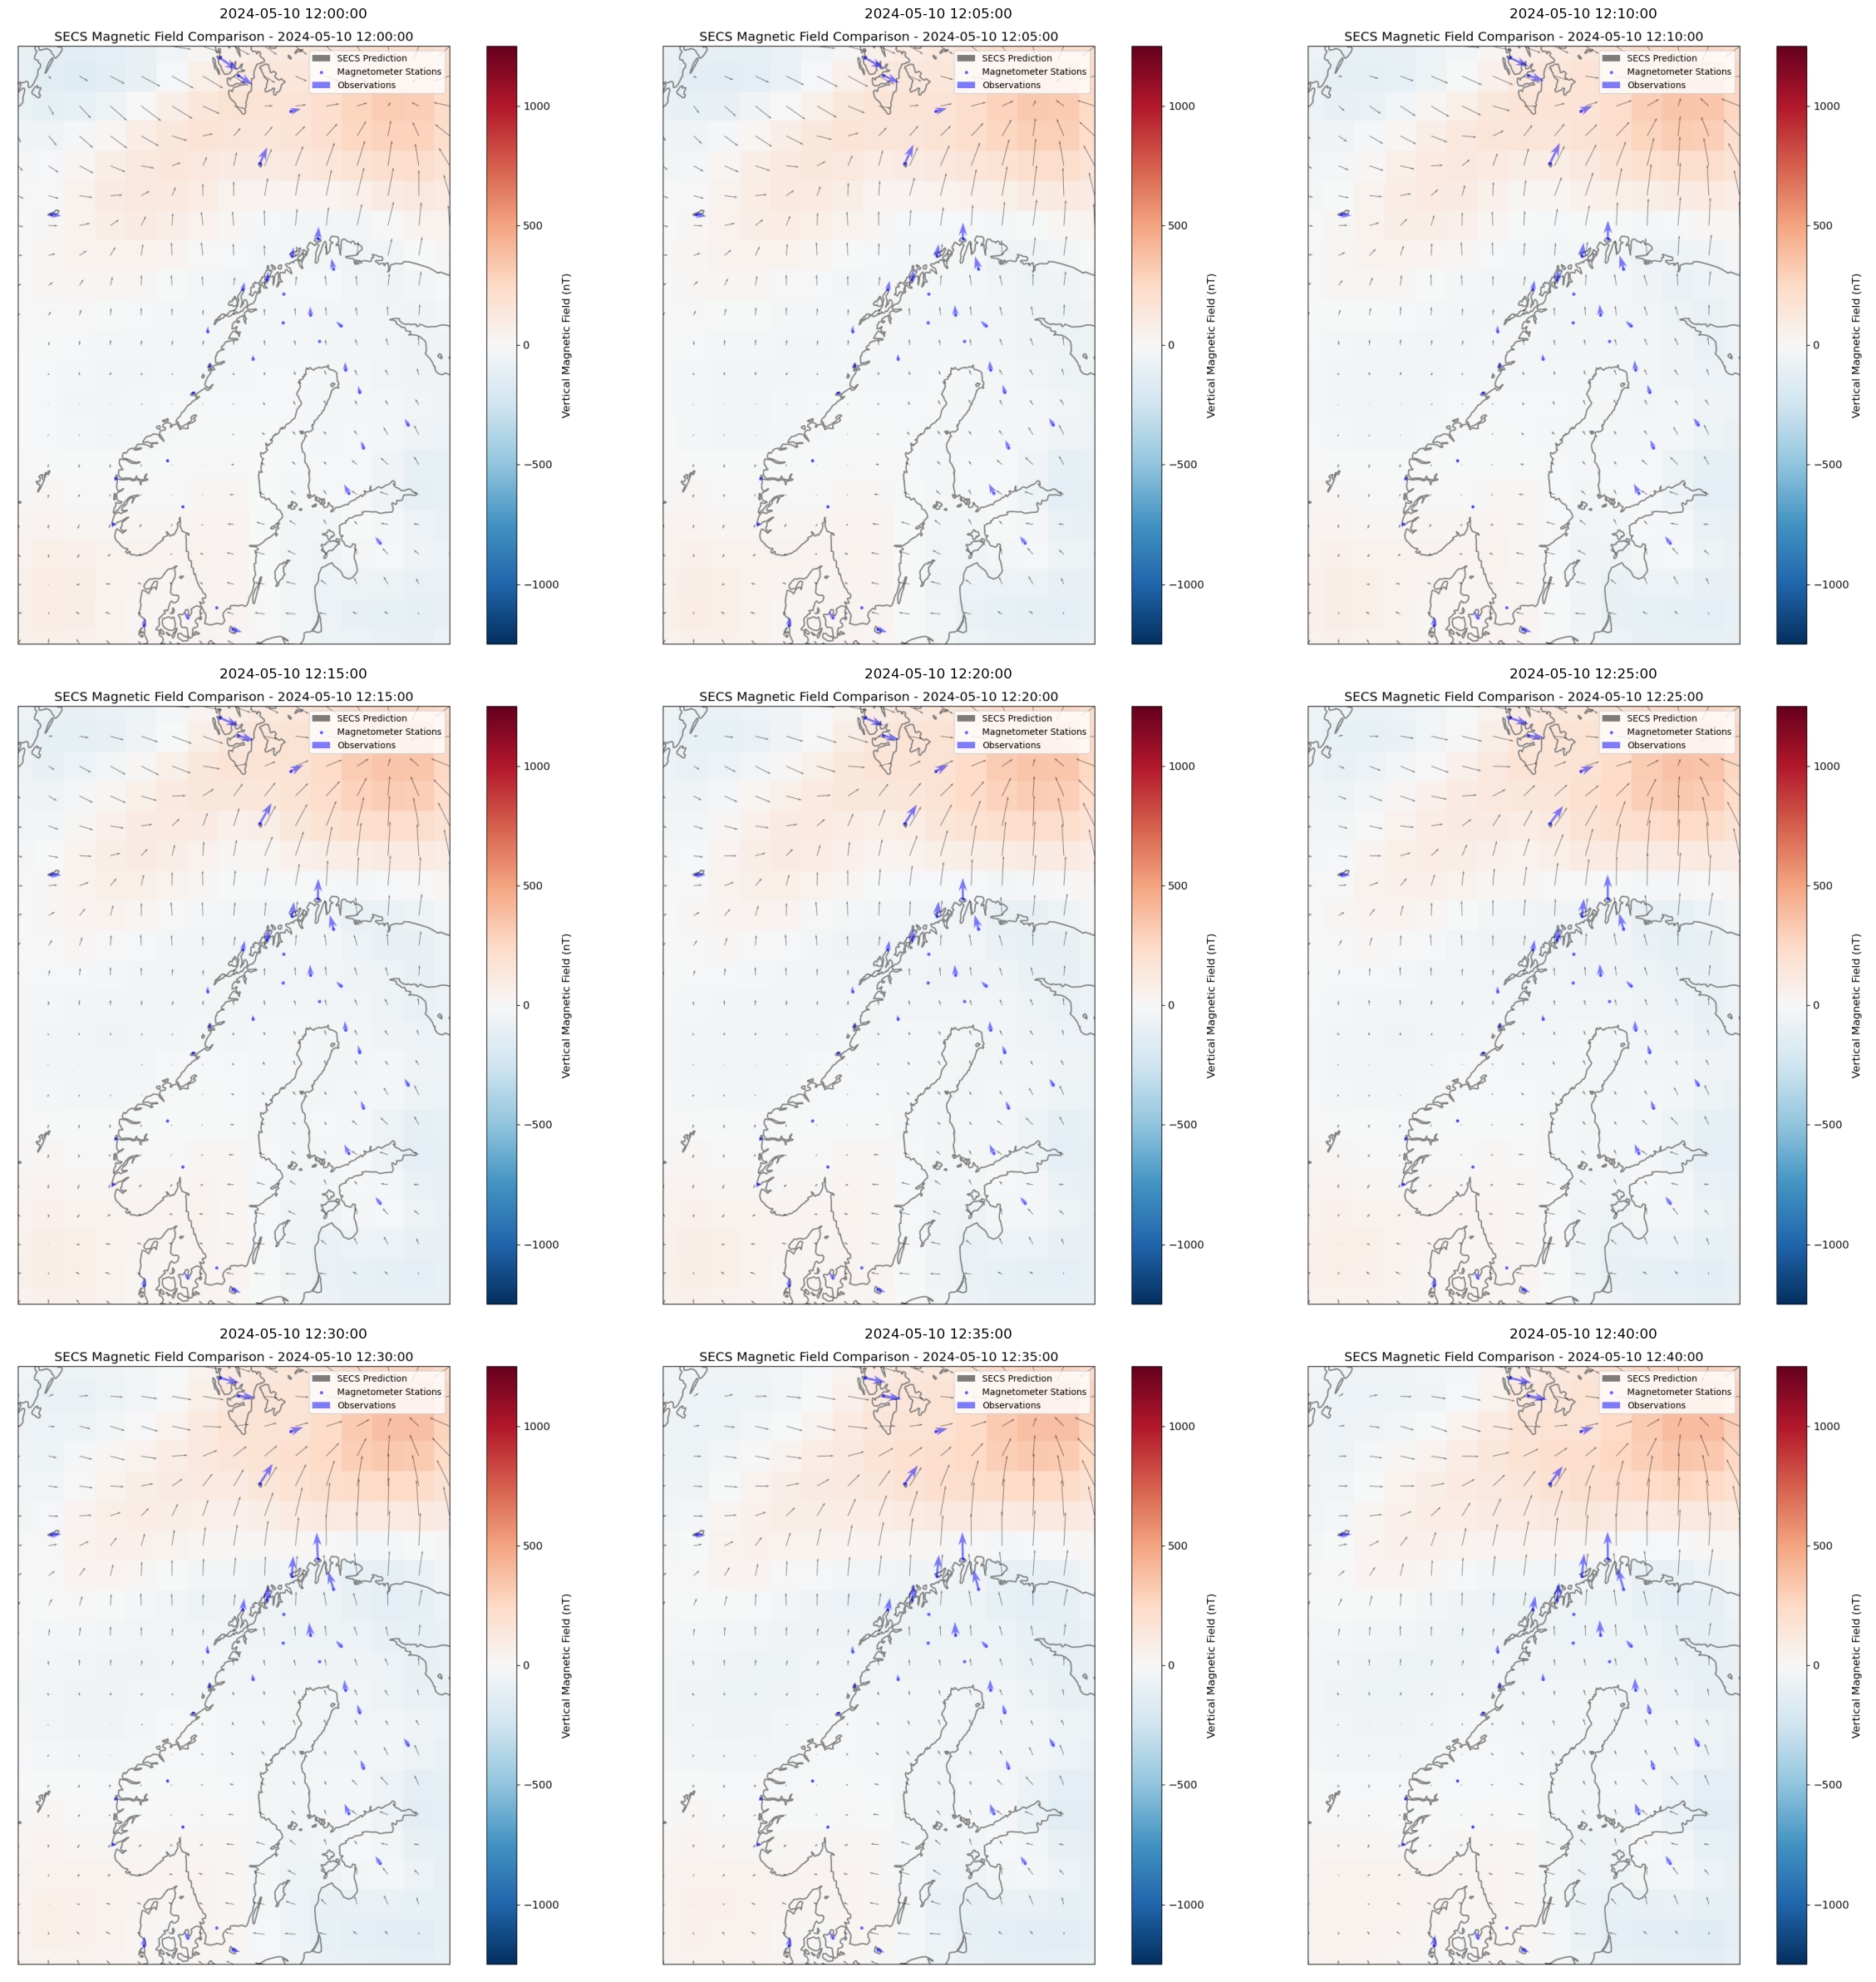

In [9]:
def display_comparison_grid():
    """
    Display a 3×3 grid of comparison plots.
    """
    print("\nDisplaying 3×3 grid of comparison plots...")
    
    # Create a figure with 3×3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(24, 24))
    axes = axes.flatten()
    
    # Sort timestamps
    sorted_times = sorted(comparison_plots.keys())
    
    # Display each comparison plot
    for i, timestamp in enumerate(sorted_times):
        if i >= 9:  # Limit to 9 plots
            break
            
        # Load the image
        img = plt.imread(comparison_plots[timestamp])
        
        # Display in the appropriate subplot
        axes[i].imshow(img)
        axes[i].set_title(f"{timestamp}", fontsize=12)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the comparison grid
display_comparison_grid()

### Understanding the Comparison Plots

The comparison plots above provide a visual assessment of how well our SECS model captures the actual magnetic field variations. Here's how to interpret these plots:

1. **Color Map (Background)**:
   - Shows the vertical magnetic field component (Bu)
   - Red indicates upward field (positive Bu)
   - Blue indicates downward field (negative Bu)
   - The color scale ranges from -750 nT to +750 nT

2. **Black Arrows**:
   - Represent the SECS-predicted horizontal magnetic field
   - Direction shows the field orientation
   - Length indicates field strength

3. **Blue Arrows**:
   - Represent the observed horizontal magnetic field at magnetometer stations
   - These are the actual measurements from the magnetometers
   - Blue dots show the station locations

4. **Scale Reference**:
   - The '500 nT' label in the upper left provides a scale reference for the arrow length

5. **Coastlines**:
   - Grey lines show coastlines for geographic reference
   - The map is projected using a cubed-sphere projection centered on our region of interest

6. **Comparison Assessment**:
   - Good agreement between black and blue arrows indicates the SECS model is accurately capturing the magnetic field pattern
   - Discrepancies may indicate limitations in the model, data quality issues, or areas with poor station coverage

These comparison plots help validate our SECS inversion results and provide insight into the ionospheric current systems responsible for the observed magnetic field variations.

## 4. RGB Visualization for Machine Learning

While the comparison plots in Section 3 provide an intuitive visualization for human interpretation, we also need a representation that's suitable for machine learning applications. The RGB visualization technique encodes the three magnetic field components (Be, Bn, Bu) as color channels in a single image, creating a compact representation that's ideal for training neural networks.

This approach is particularly valuable for developing time-dependent models like convolutional LSTMs that can forecast magnetic field evolution based on solar wind parameters and other geophysical inputs. The RGB mapping is as follows:

- **Red channel**: Eastward component (Be)
- **Green channel**: Northward component (Bn)
- **Blue channel**: Upward component (Bu)

### Statistical Normalization Approach

Geomagnetic field data typically follows a distribution where most values cluster around zero, with fewer observations at the extremes. A linear mapping from the full range to 8-bit pixel values (0-255) would allocate the same number of discrete levels to all parts of the range, which is inefficient.

Instead, we implement a statistical normalization based on the cumulative distribution function (CDF) of a normal distribution. This approach:

1. Allocates more pixel levels to the common value ranges near zero
2. Allocates fewer pixel levels to the extreme values that occur less frequently
3. Ensures a smooth, statistically informed mapping that maximizes information content

The mapping uses the CDF of a normal distribution centered at zero, with a standard deviation (σ) chosen to appropriately cover the expected range of magnetic field values. With this approach:

- Values at the center (0 nT) map to the middle pixel value (128)
- Values within ±1σ use approximately 68% of the available pixel levels
- Values within ±2σ use approximately 95% of the available pixel levels
- Extreme values beyond ±3σ are compressed into the remaining pixel levels

In [10]:
# Define the standard deviation for statistical normalization
# This parameter controls the allocation of pixel values:
# - Smaller values give higher resolution near zero but compress extremes more
# - Larger values give more even distribution but less resolution near zero
# A good starting point is to use std = max_expected_value/2
STAT_NORM_STD = 500  # Can be adjusted based on the desired mapping

def create_rgb_image_statistical(be, bn, bu, std=STAT_NORM_STD, vmin=None, vmax=None):
    """
    Create an RGB image from magnetic field components using statistical normalization.
    
    The function maps each component to a color channel using a normal CDF mapping:
    - Red: Eastward component (Be)
    - Green: Northward component (Bn)
    - Blue: Upward component (Bu)
    
    Statistical normalization using the normal CDF:
    1. For each value x, calculate Φ(x/σ) where Φ is the normal CDF
    2. This maps the range (-∞,+∞) to (0,1) with 0 mapping to 0.5
    3. Values within ±1σ use ~68% of the pixel range
    4. Values within ±2σ use ~95% of the pixel range
    
    Args:
        be (numpy.ndarray): Eastward magnetic field component
        bn (numpy.ndarray): Northward magnetic field component
        bu (numpy.ndarray): Upward magnetic field component
        std (float): Standard deviation parameter for normalization
        vmin (float): Minimum expected value (for reference only)
        vmax (float): Maximum expected value (for reference only)
        
    Returns:
        numpy.ndarray: RGB image array with values in [0, 255] (uint8)
    """
    from scipy.stats import norm
    
    def normalize_to_uint8_normal_dist(data):
        # Calculate CDF values (between 0 and 1)
        # This maps the data to a probability using the normal distribution
        cdf_values = norm.cdf(data / std)
        
        # Map to 0-255 range for 8-bit pixel values
        pixel_values = (cdf_values * 255).astype(np.uint8)
        
        return pixel_values
    
    # Normalize each component to 8-bit (0-255)
    r = normalize_to_uint8_normal_dist(be)
    g = normalize_to_uint8_normal_dist(bn)
    b = normalize_to_uint8_normal_dist(bu)
    
    # Stack the components to create an RGB image
    rgb = np.stack([r, g, b], axis=2)
    
    return rgb

# Update the RGB images in our results using the statistical normalization
for timestamp in results.keys():
    be = results[timestamp]['Be']
    bn = results[timestamp]['Bn']
    bu = results[timestamp]['Bu']
    
    # Create RGB image with statistical normalization
    results[timestamp]['rgb_image'] = create_rgb_image_statistical(
        be, bn, bu, 
        std=STAT_NORM_STD,
        vmin=vmin_rgb, 
        vmax=vmax_rgb
    )


Displaying 3×3 grid of RGB visualizations (std=500 nT)...

Overall Statistics Across All Timestamps:
Be (Eastward): mean=15.07 nT, min=-148.22 nT, max=186.75 nT
Bn (Northward): mean=43.43 nT, min=-128.61 nT, max=285.63 nT
Bu (Upward): mean=14.65 nT, min=-152.33 nT, max=387.46 nT

RGB Pixel Values:
Red channel: mean=130.04, min=97, max=164
Green channel: mean=135.72, min=101, max=182
Blue channel: mean=129.75, min=96, max=199


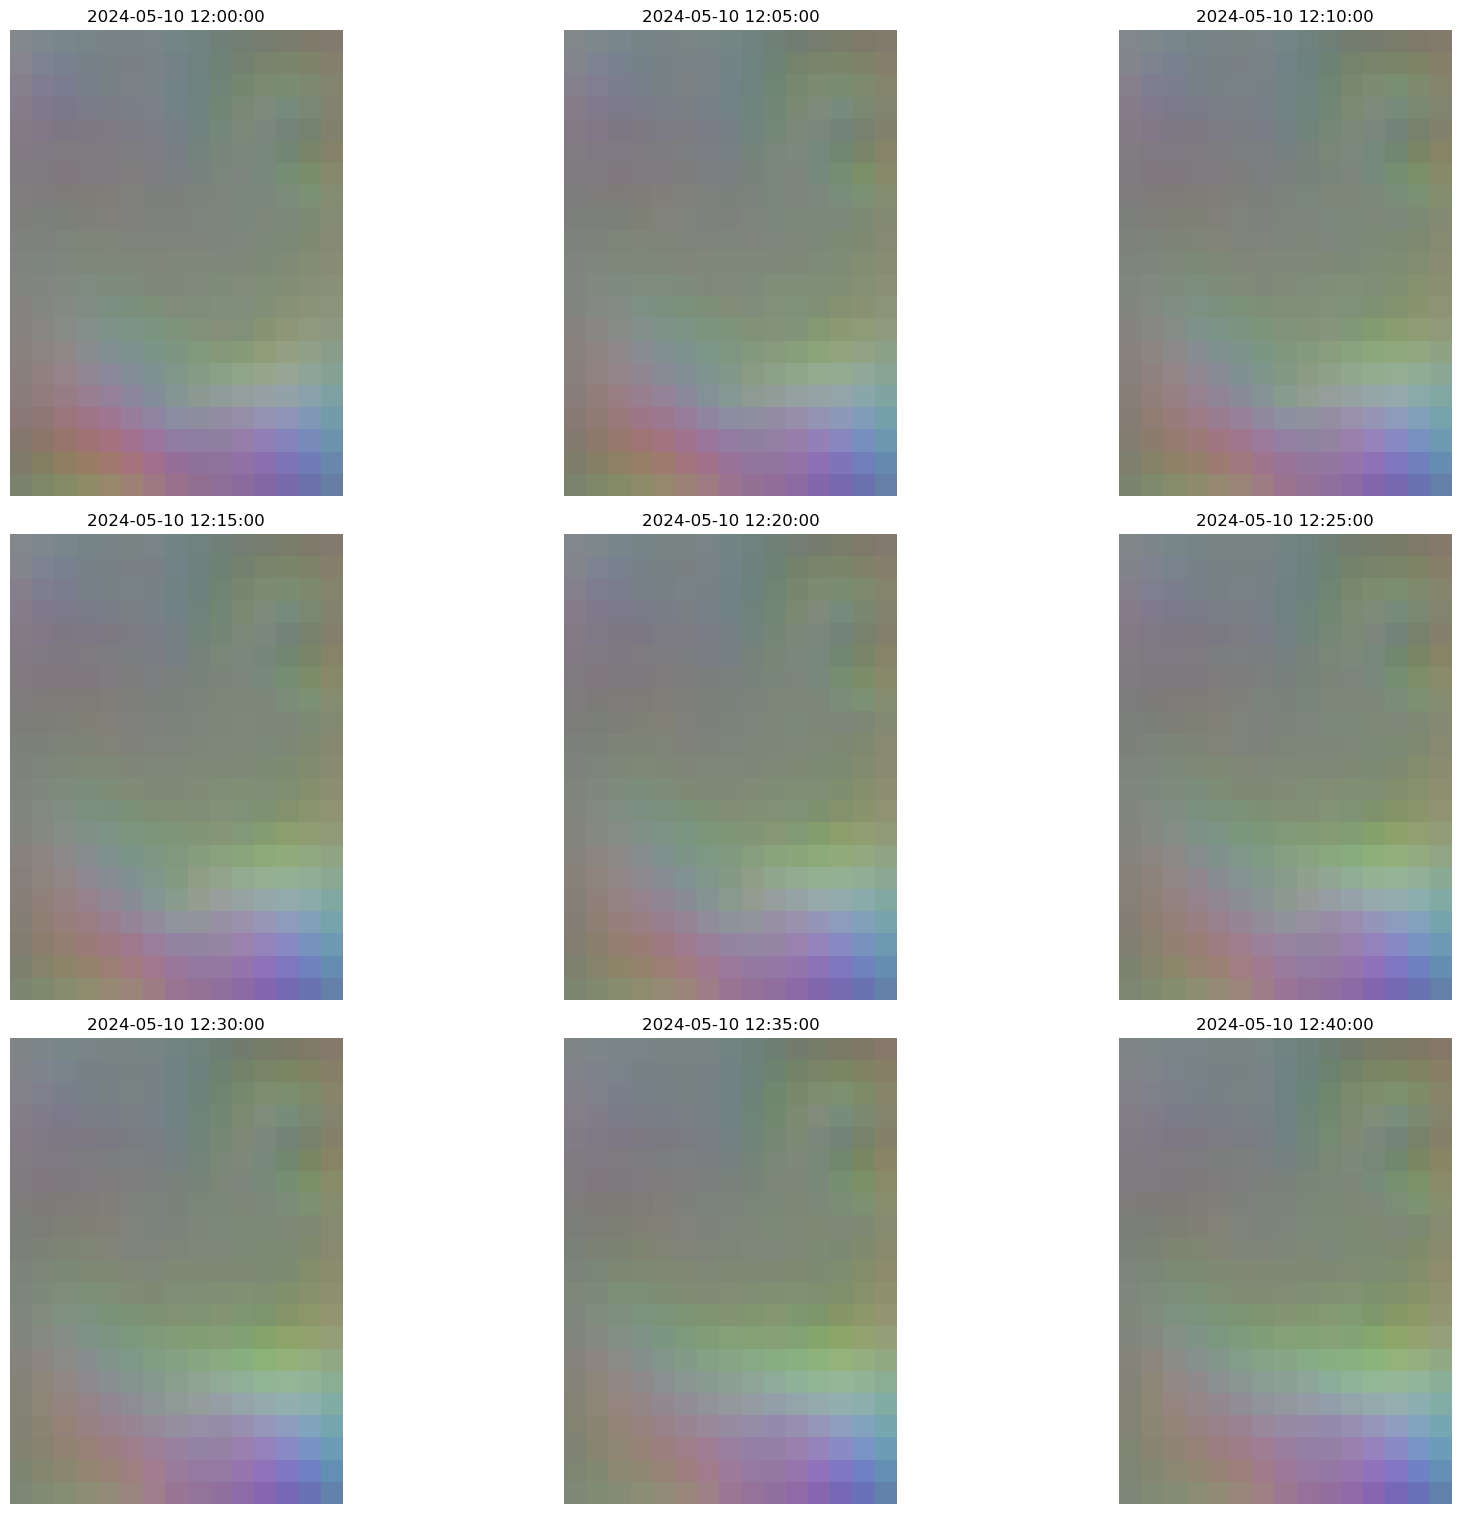

In [11]:
def display_rgb_grid(std=STAT_NORM_STD):
    """
    Display a 3×3 grid of RGB visualizations and print statistics for each channel.
    
    Args:
        std (float): Standard deviation used in the normalization (for display only)
    """
    print(f"\nDisplaying 3×3 grid of RGB visualizations (std={std} nT)...")
    
    # Create a figure with 3×3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten()
    
    # Sort timestamps
    sorted_times = sorted(results.keys())
    
    # Collect all component values across timestamps for statistics
    all_be = []
    all_bn = []
    all_bu = []
    all_r = []
    all_g = []
    all_b = []
    
    # Display each RGB image
    for i, timestamp in enumerate(sorted_times):
        if i >= 9:  # Limit to 9 plots
            break
            
        # Get the RGB image and original magnetic field components
        rgb_img = results[timestamp]['rgb_image']
        be = results[timestamp]['Be']
        bn = results[timestamp]['Bn']
        bu = results[timestamp]['Bu']
        
        # Collect values for statistics
        all_be.append(be)
        all_bn.append(bn)
        all_bu.append(bu)
        all_r.append(rgb_img[:,:,0])
        all_g.append(rgb_img[:,:,1])
        all_b.append(rgb_img[:,:,2])
        
        # Display in the appropriate subplot
        axes[i].imshow(rgb_img)
        axes[i].set_title(f"{timestamp}", fontsize=12)
        axes[i].axis('off')
    
    # Combine arrays for overall statistics
    all_be = np.concatenate([arr.flatten() for arr in all_be])
    all_bn = np.concatenate([arr.flatten() for arr in all_bn])
    all_bu = np.concatenate([arr.flatten() for arr in all_bu])
    all_r = np.concatenate([arr.flatten() for arr in all_r])
    all_g = np.concatenate([arr.flatten() for arr in all_g])
    all_b = np.concatenate([arr.flatten() for arr in all_b])
    
    # Print overall statistics
    print("\nOverall Statistics Across All Timestamps:")
    print(f"Be (Eastward): mean={all_be.mean():.2f} nT, min={all_be.min():.2f} nT, max={all_be.max():.2f} nT")
    print(f"Bn (Northward): mean={all_bn.mean():.2f} nT, min={all_bn.min():.2f} nT, max={all_bn.max():.2f} nT")
    print(f"Bu (Upward): mean={all_bu.mean():.2f} nT, min={all_bu.min():.2f} nT, max={all_bu.max():.2f} nT")
    print(f"\nRGB Pixel Values:")
    print(f"Red channel: mean={all_r.mean():.2f}, min={all_r.min()}, max={all_r.max()}")
    print(f"Green channel: mean={all_g.mean():.2f}, min={all_g.min()}, max={all_g.max()}")
    print(f"Blue channel: mean={all_b.mean():.2f}, min={all_b.min()}, max={all_b.max()}")
        
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# Display the RGB grid
display_rgb_grid(std=STAT_NORM_STD)

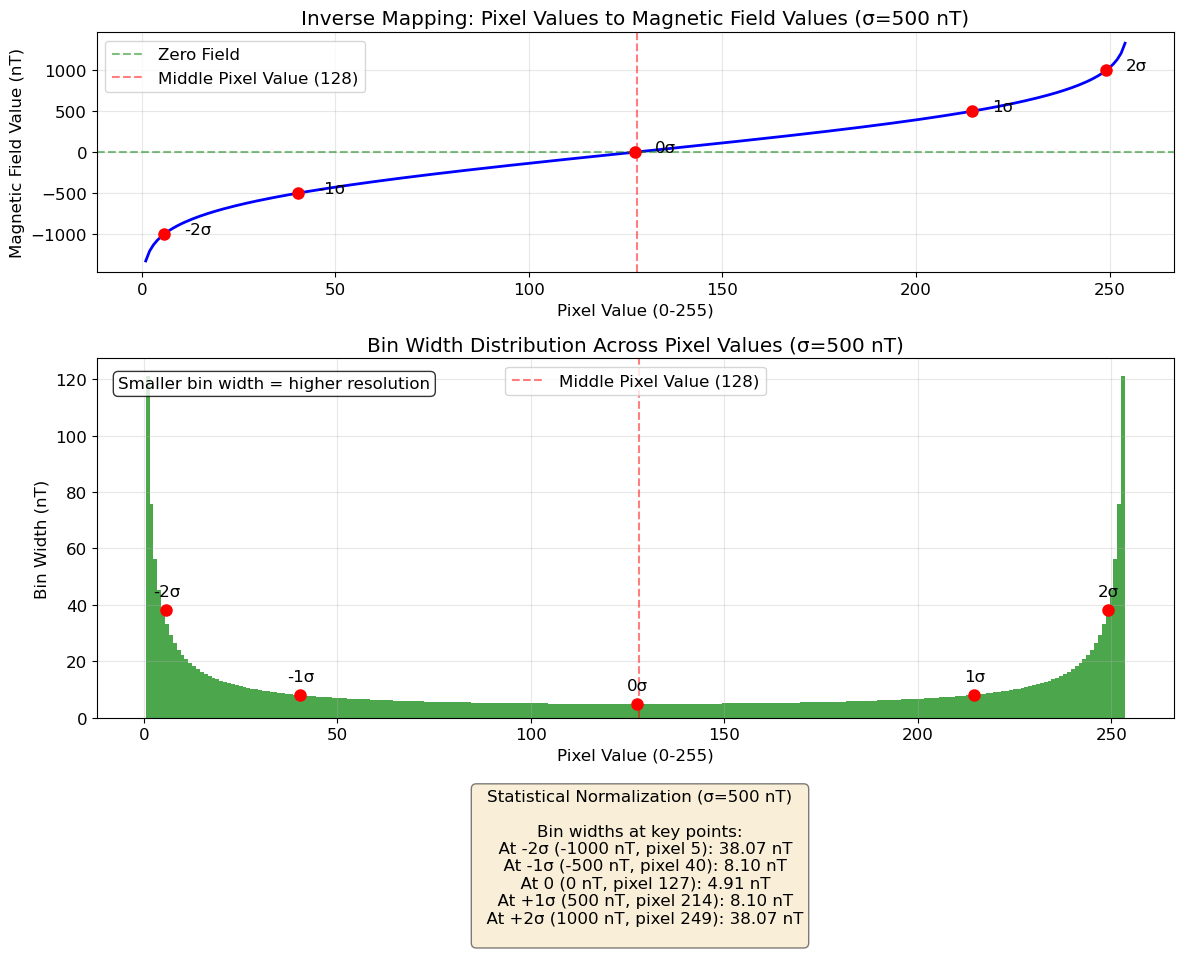

In [12]:
def plot_pixel_bin_distribution(std=STAT_NORM_STD, vmin=-1500, vmax=1500):
    """
    Plot the pixel bin width distribution for the statistical normalization.
    
    This shows how the 256 available pixel values are allocated across the
    magnetic field value range, highlighting the non-linear nature of the mapping.
    
    Statistical normalization explanation:
    - Uses normal CDF to map magnetic field values to pixel values
    - Values at 0 nT map to pixel value 128
    - Values at ±1σ map to pixels ~40 and ~215 (68% of range)
    - Values at ±2σ map to pixels ~6 and ~249 (95% of range)
    - Bin widths are smallest near 0 nT (highest resolution)
    - Bin widths increase toward extremes (lower resolution)
    
    Args:
        std (float): Standard deviation used in the normalization
        vmin (float): Minimum magnetic field value to display
        vmax (float): Maximum magnetic field value to display
    """
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    
    # Create an array of all possible pixel values (0-255)
    pixel_values = np.arange(256)
    
    # Convert pixel values back to probabilities (0-1)
    probabilities = pixel_values / 255
    
    # Convert probabilities to magnetic field values using the inverse CDF (ppf)
    field_values = norm.ppf(probabilities) * std
    
    # Calculate bin widths by taking the difference between consecutive field values
    bin_widths = np.diff(field_values)
    
    # Add a placeholder for the last bin width (use the same as the second-to-last)
    bin_widths = np.append(bin_widths, bin_widths[-1])
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1.5]})
    
    # Plot 1: Mapping from pixel values to magnetic field values (inverse of original mapping)
    ax1.plot(pixel_values, field_values, 'b-', linewidth=2)
    ax1.set_xlabel('Pixel Value (0-255)')
    ax1.set_ylabel('Magnetic Field Value (nT)')
    ax1.set_title(f'Inverse Mapping: Pixel Values to Magnetic Field Values (σ={std} nT)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='g', linestyle='--', alpha=0.5, label='Zero Field')
    ax1.axvline(x=128, color='r', linestyle='--', alpha=0.5, label='Middle Pixel Value (128)')
    
    # Add standard deviation markers
    for i, mult in enumerate([-2, -1, 0, 1, 2]):
        y_val = mult * std
        x_val = norm.cdf(mult) * 255
        ax1.plot(x_val, y_val, 'ro', markersize=8)
        ax1.text(x_val + 5, y_val, f'{mult}σ', fontsize=12)
    
    ax1.legend()
    
    # Plot 2: Bin width for each pixel value
    ax2.bar(pixel_values, bin_widths, width=1.0, color='g', alpha=0.7)
    ax2.set_xlabel('Pixel Value (0-255)')
    ax2.set_ylabel('Bin Width (nT)')
    ax2.set_title(f'Bin Width Distribution Across Pixel Values (σ={std} nT)')
    ax2.grid(True, alpha=0.3)
    
    # Add vertical line at middle pixel value
    ax2.axvline(x=128, color='r', linestyle='--', alpha=0.5, label='Middle Pixel Value (128)')
    
    # Add standard deviation markers
    for i, mult in enumerate([-2, -1, 0, 1, 2]):
        x_val = norm.cdf(mult) * 255
        y_val = 0  # Start at bottom
        if 0 <= x_val < 255:
            pixel_idx = int(x_val)
            bin_height = bin_widths[pixel_idx]
            ax2.plot(x_val, bin_height, 'ro', markersize=8)
            ax2.text(x_val, bin_height + 5, f'{mult}σ', 
                     horizontalalignment='center', fontsize=12)
    
    # Add explanation text
    ax2.text(0.02, 0.95, 'Smaller bin width = higher resolution', 
             transform=ax2.transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.legend()
    
    # Calculate and display some key statistics
    middle_pixel = 128
    
    # Find bin widths at standard deviation points
    minus_2sigma_pixel = int(norm.cdf(-2) * 255)
    minus_1sigma_pixel = int(norm.cdf(-1) * 255)
    zero_sigma_pixel = int(norm.cdf(0) * 255)
    plus_1sigma_pixel = int(norm.cdf(1) * 255)
    plus_2sigma_pixel = int(norm.cdf(2) * 255)
    
    minus_2sigma_width = bin_widths[minus_2sigma_pixel]
    minus_1sigma_width = bin_widths[minus_1sigma_pixel]
    zero_sigma_width = bin_widths[zero_sigma_pixel]
    plus_1sigma_width = bin_widths[plus_1sigma_pixel]
    plus_2sigma_width = bin_widths[plus_2sigma_pixel]
    
    stats_text = (
        f"Statistical Normalization (σ={std} nT)\n\n"
        f"Bin widths at key points:\n"
        f"  At -2σ ({-2*std:.0f} nT, pixel {minus_2sigma_pixel}): {minus_2sigma_width:.2f} nT\n"
        f"  At -1σ ({-1*std:.0f} nT, pixel {minus_1sigma_pixel}): {minus_1sigma_width:.2f} nT\n"
        f"  At 0 (0 nT, pixel {zero_sigma_pixel}): {zero_sigma_width:.2f} nT\n"
        f"  At +1σ ({1*std:.0f} nT, pixel {plus_1sigma_pixel}): {plus_1sigma_width:.2f} nT\n"
        f"  At +2σ ({2*std:.0f} nT, pixel {plus_2sigma_pixel}): {plus_2sigma_width:.2f} nT\n"
    )
    
    plt.figtext(0.54, 0.001, stats_text, ha="center", fontsize=12, 
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    
    plt.tight_layout(rect=[0, 0.16, 1, 0.95])
    plt.show()

# Plot the pixel bin distribution for our normalization
plot_pixel_bin_distribution(std=STAT_NORM_STD, vmin=-1500, vmax=1500)

### Benefits of Statistical Normalization for Machine Learning

The statistical normalization approach offers several advantages for machine learning applications:

1. **Optimized Information Content**: By allocating more pixel levels to the value ranges where most data points occur, we maximize the information content of the images for the neural network.

2. **Enhanced Feature Resolution**: The approach provides higher resolution in the central region of the distribution where subtle features and patterns are most likely to occur.

3. **Robust to Outliers**: Extreme values are still represented but compressed into fewer pixel levels, making the representation robust to outliers without clipping information.

4. **Statistically Informed**: The mapping is based on the expected statistical distribution of the data, making it more principled than arbitrary non-linear transformations.

5. **Adaptable**: The standard deviation parameter (σ) can be adjusted based on the specific characteristics of the dataset and the desired allocation of pixel values.

This RGB visualization approach provides a standardized input format for training time-dependent neural networks like convolutional LSTMs. By encoding the full 3D magnetic field vector into a single RGB image with appropriate statistical normalization, we create an efficient representation that preserves the essential spatial and vector information needed for forecasting applications.